## Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

import utils.training as train_utils; imp.reload(train_utils)
#import utils.plot as plot_utils; imp.reload(plot_utils)

import camvid_dataset as camvid
import joint_transforms
%matplotlib inline

In [3]:
DATA_PATH='data/'
RESULTS_PATH='results/'
WEIGHTS_PATH='models/'
CAMVID_PATH=DATA_PATH+'CamVid/'
EXPERIMENT='tiramisu'

## Design

**FirstConvLayer**

* 3x3 Conv2D (pad=, stride=, in_chans=3, out_chans=48)

**DenseLayer**

* BatchNorm
* ReLU
* 3x3 Conv2d (pad=, stride=, in_chans=, out_chans=) - "no resolution loss" - padding included
* Dropout (.2)

**DenseBlock**

* Input = FirstConvLayer, TransitionDown, or TransitionUp
* Loop to create L DenseLayers (L=n_layers)
* On TransitionDown we Concat(Input, FinalDenseLayerActivation)
* On TransitionUp we do not Concat with input, instead pass FinalDenseLayerActivation to TransitionUp block

**TransitionDown**

* BatchNorm
* ReLU
* 1x1 Conv2D (pad=, stride=, in_chans=, out_chans=)
* Dropout (0.2)
* 2x2 MaxPooling

**Bottleneck**

* DenseBlock (15 layers)

**TransitionUp**

* 3x3 Transposed Convolution (pad=, stride=2, in_chans=, out_chans=)
* Concat(PreviousDenseBlock, SkipConnection) - from cooresponding DenseBlock on transition down

**FinalBlock**

* 1x1 Conv2d (pad=, stride=, in_chans=256, out_chans=n_classes)
* Softmax

**FCDenseNet103 Architecture**

* input (in_chans=3 for RGB)
* 3x3 ConvLayer (out_chans=48)
* DB (4 layers) + TD
* DB (5 layers) + TD
* DB (7 layers) + TD
* DB (10 layers) + TD
* DB (12 layers) + TD
* Bottleneck (15 layers)
* TU + DB (12 layers)
* TU + DB (10 layers)
* TU + DB (7 layers)
* TU + DB (5 layers)
* TU + DB (4 layers)
* 1x1 ConvLayer (out_chans=n_classes) n_classes=11 for CamVid
* Softmax

**FCDenseNet67**

* GrowthRate (k) = 16
* 5 layers per dense block
* 1 Conv Layer
* 5 DenseBlocks Downsample (25 layers)
* 5 TransitionDown
* 5 Bottleneck layers
* 5 Dense Blocks Upsample (25 layers)
* 5 TransitionUp
* 1 Conv Layer
* 1 Softmax layer (doesn't count)
67 Total layers

**360x480 Input Path**

Image dimensions that are evenly divisible are nice. The 224x224 input work nicely w/out cropping.
* skipsize torch.Size([1, 128, 360, 480])
* skipsize torch.Size([1, 208, 180, 240])
* skipsize torch.Size([1, 288, 90, 120])
* skipsize torch.Size([1, 368, 45, 60])
* skipsize torch.Size([1, 448, 22, 30])    <------- we lose 1 pixel here 22.5 to 22 b/c of rounding
* bnecksize torch.Size([1, 80, 11, 15])
* insize torch.Size([1, 80, 11, 15])
* outsize torch.Size([1, 80, 22, 30])   
* insize torch.Size([1, 80, 22, 30])  <--------- we need to crop/pad to recover that lost pixel
* outsize torch.Size([1, 80, 45, 60])
* insize torch.Size([1, 80, 45, 60])
* outsize torch.Size([1, 80, 90, 120])
* insize torch.Size([1, 80, 90, 120])
* outsize torch.Size([1, 80, 180, 240])
* insize torch.Size([1, 80, 180, 240])
* outsize torch.Size([1, 80, 360, 480])


**224x224 Input Path**
* skipsize torch.Size([3, 128, 224, 224])
* skipsize torch.Size([3, 208, 112, 112])
* skipsize torch.Size([3, 288, 56, 56])
* skipsize torch.Size([3, 368, 28, 28])
* skipsize torch.Size([3, 448, 14, 14])
* bnecksize torch.Size([3, 80, 7, 7])
* insize torch.Size([3, 80, 7, 7])
* outsize torch.Size([3, 80, 14, 14])
* insize torch.Size([3, 80, 14, 14])
* outsize torch.Size([3, 80, 28, 28])
* insize torch.Size([3, 80, 28, 28])
* outsize torch.Size([3, 80, 56, 56])
* insize torch.Size([3, 80, 56, 56])
* outsize torch.Size([3, 80, 112, 112])
* insize torch.Size([3, 80, 112, 112])
* outsize torch.Size([3, 80, 224, 224])

## Layers

In [4]:
def center_crop(layer, max_height, max_width):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
    #Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

In [5]:
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
              padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
        #self.updample2d = nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

## Model

In [6]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5), 
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super(FCDenseNet, self).__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        
        cur_channels_count = 0
        skip_connection_channel_counts = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(cur_channels_count, 
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i], 
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

            
        #One final dense block
        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1], 
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print("INPUT",x.size())
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(len(self.down_blocks)):
            #print("DBD size",out.size())
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        #print ("bnecksize",out.size())
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            #print("DOWN_SKIP_PRE_UPSAMPLE",out.size(),skip.size())
            out = self.transUpBlocks[i](out, skip)
            #print("DOWN_SKIP_AFT_UPSAMPLE",out.size(),skip.size())
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        out = self.softmax(out)
        return out
    
def FCDenseNet57(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4, 4, 4, 4, 4), 
                 up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4, 
                 growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet67(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(5, 5, 5, 5, 5), 
                 up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet103(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4,5,7,10,12), 
                 up_blocks=(12,10,7,5,4), bottleneck_layers=15, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

In [7]:
print(FCDenseNet103(12))

FCDenseNet (
  (firstconv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (denseBlocksDown): ModuleList (
    (0): DenseBlock (
      (layers): ModuleList (
        (0): DenseLayer (
          (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplace)
          (conv): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (drop): Dropout2d (p=0.2)
        )
        (1): DenseLayer (
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplace)
          (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (drop): Dropout2d (p=0.2)
        )
        (2): DenseLayer (
          (norm): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU (inplace)
          (conv): Conv2d(80, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (drop): Dropout2d (p=0.2)
        )
        (3): DenseLayer (
          (no

## Data


* https://github.com/SimJeg/FC-DenseNet/blob/master/data_loader.py
* https://github.com/pytorch/vision/pull/90
* https://github.com/SimJeg/FC-DenseNet/issues/10


**CamVid**

* TrainingSet = 367 frames
* ValidationSet = 101 frames
* TestSet = 233 frames
* Images of resolution 360x480
* Images "Cropped" to 224x224 for training --- center crop?
* FullRes images used for finetuning
* NumberOfClasses = 11 (output)
* BatchSize = 3


In [8]:
batch_size = 3
seed = 0
torch.cuda.manual_seed(seed)

In [9]:
traindir = os.path.join(CAMVID_PATH, 'train')
valdir = os.path.join(CAMVID_PATH, 'val')
testdir = os.path.join(CAMVID_PATH, 'test')

normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomCrop(224),
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=1, shuffle=False)

In [10]:
# print(train_loader.dataset.classes)
# print(train_loader.dataset.class_weight)
# print(train_loader.dataset.imgs[:3])
# print(train_loader.dataset.mean)
# print(train_loader.dataset.std)
print("TrainImages: %d" %len(train_loader.dataset.imgs))
print("ValImages: %d" %len(val_loader.dataset.imgs))
print("TestImages: %d" %len(test_loader.dataset.imgs))
print("NumClasses: %d" % len(train_loader.dataset.classes))

example_inputs, example_targets = next(iter(train_loader))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

#Inputs are tensors of normalized pixel values
print ("\nInput (size, max, min) ---")
i = example_inputs[0]
print (i.size())
print(i.max())
print(i.min())


#Targets are tensors of class labels from 0-11 (0 means background)
print ("Target (size, max, min) ---")
t = example_targets[0]
print(t.size())
print(t.max())
print(t.min())

TrainImages: 367
ValImages: 101
TestImages: 233
NumClasses: 12
InputsBatchSize:  torch.Size([3, 3, 224, 224])
TargetsBatchSize:  torch.Size([3, 224, 224])

Input (size, max, min) ---
torch.Size([3, 224, 224])
2.145308017730713
-1.5025229454040527
Target (size, max, min) ---
torch.Size([224, 224])
11
0


## Visualize

* https://discuss.pytorch.org/t/convert-pixel-wise-class-tensor-to-image-segmentation/1268
* http://www.colorspire.com/rgb-color-wheel/ (verify RGB colors)

In [11]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
      Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(camvid.mean)
    std = np.array(camvid.std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    """Imshow for Tensor."""
    inp = decode_image(tensor)
    plt.imshow(inp)
    plt.show()

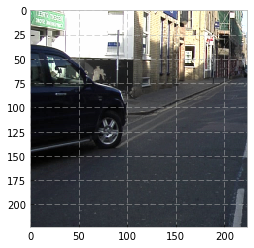

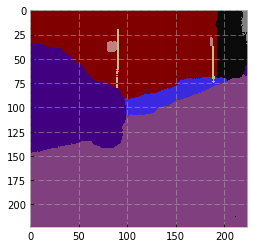

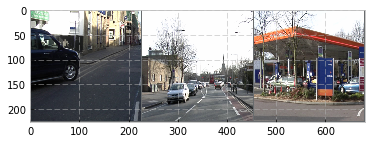

In [12]:
# Get a batch of training data
inputs, targets = next(iter(train_loader))
#inputs, targets = next(iter(val_loader))
#inputs, targets = next(iter(test_loader))

# Plot Single Image
view_image(inputs[0])

# Plot Target Image
view_annotated(targets[0])

# Plot Grid of images
out = torchvision.utils.make_grid(inputs, nrow=3)
view_image(out)

## Visdom web browser

* https://github.com/facebookresearch/visdom
* https://github.com/facebookresearch/visdom/blob/master/example/demo.py

In [13]:
visdom_enabled = True
import visdom
viz = visdom.Visdom()

In [14]:
def viz_plot_tst_trn(window, epoch, tst_val, trn_val, name='loss', env='main'):
    if window is None:
        return viz.line(
            X=np.array([epoch]),
            Y=np.array([[tst_val, trn_val]]),
            opts=dict(
                xlabel='epoch',
                ylabel=name,
                title=env+' '+name,
                legend=['Validation', 'Train']
            ),
            env=env
        )
    return viz.line(
        X=np.ones((1, 2)) * epoch,
        Y=np.expand_dims([tst_val, trn_val],0),
        win=window,
        update='append',
        env=env
    )

def viz_plot_img(window, tensor, env='main', title='Image'):
    '''
    This function draws an img on your Visdom web app. 
    It takes as input an `CxHxW` tensor `img`
    The array values can be float in [0,1] or uint8 in [0, 255]'''
    np_img = decode_image(tensor)
    np_img = np.rollaxis(np_img, 2, 0)
    viz.image(
        np_img,
        opts=dict(title=title, caption='Silly image'),
        win=window,
        env=env
    )
    
def viz_plot_text(window, text, env='main'):
    if window is None:
        return viz.text(
            text,
            env=env
        )
    return viz.text(
        text,
        win=window,
        env=env
    )

def viz_plot_summary(window, epoch, tst_loss, trn_loss,
                       tst_err, trn_err, env='main'):
    txt = ("""Epoch: %d
        Train - Loss: %d Err: %d
        Test - Loss: %d Err: %d""" % (epoch, 
        trn_loss, trn_err, tst_loss, tst_err))
    return viz_plot_text(window, txt, env)

In [15]:
#Should plot one chart and update it
txt_chart = viz_plot_summary(None, 1, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 3, 8, 7, 6)

In [16]:
#Should plot one chart and update it
sum_chart = viz_plot_text(None, 'Hello, world3!')
sum_chart = viz_plot_text(sum_chart, 'Hello, world4!')

In [17]:
#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
loss_chart = viz_plot_tst_trn(None, 9, 14, 27, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 10, 18, 30, 'loss')
loss_chart = viz_plot_tst_trn(loss_chart, 11, 19, 32, 'loss')

In [18]:
#Should plot one chart and update it
#window, epoch, tst_val, trn_val, name='loss', env='main'
err_chart = viz_plot_tst_trn(None, 9, 14, 27, 'error')
err_chart = viz_plot_tst_trn(err_chart, 10, 18, 30, 'error')
err_chart = viz_plot_tst_trn(err_chart, 11, 19, 32, 'error')

In [19]:
inputs, targets = next(iter(train_loader))
img_chart = viz.image(
    np.random.rand(3,360,480),
    opts=dict(title="Image", caption='Silly random'),
)
viz_plot_img(img_chart, inputs[1])

## Loss

* https://github.com/ycszen/pytorch-ss/blob/master/loss.py
* http://pytorch.org/docs/nn.html?highlight=logsoftmax#nllloss2d
* https://github.com/SimJeg/FC-DenseNet/blob/master/metrics.py
* https://cs231n.github.io/linear-classify/#softmax-classifier

## Train

* https://github.com/pytorch/examples/blob/master/imagenet/main.py

**Hyperparameters**

* WeightInitialization = HeUniform
* Optimizer = RMSProp
* LR = .001 with exponential decay of 0.995 after each epoch
* Data Augmentation = Random Crops, Vertical Flips
* ValidationSet with early stopping based on IoU or MeanAccuracy with patience of 100 (50 during finetuning)
* WeightDecay = .0001
* Finetune with full-size images, LR = .0001
* Dropout = 0.2
* BatchNorm "we use current batch stats at training, validation, and test time"

In [20]:
def get_predictions(output_batch):
    # Variables(Tensors) of size (bs,12,224,224)
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    # Argmax along channel axis (softmax probabilities)
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = 100.*incorrect/n_pixels
    return round(err,5)
        
def train(model, trn_loader, optimizer, criterion, epoch):
    model.train()
    trn_loss = 0
    trn_error = 0
    for batch_idx, (inputs, targets) in enumerate(trn_loader):
        inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        trn_loss += loss.data[0]
        pred = get_predictions(output)
        trn_error += error(pred, targets.data.cpu())
    trn_loss /= len(trn_loader) #n_batches
    trn_error /= len(trn_loader)
    return trn_loss, trn_error

def test(model, test_loader, criterion, epoch=1):
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader) #n_batches
    test_error /= len(test_loader)
    return test_loss, test_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #kaiming is first name of author whose last name is 'He' lol
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

def save_weights(model, epoch, loss, err, experiment, isBest=False):
    weights_fname = experiment+'-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch+1,
            'loss':loss,
            'error': err,
            'sessionName': experiment,
            'state_dict': model.state_dict()
        }, weights_fpath )
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest.pth')
    if isBest:
        shutil.copyfile(weights_fpath, WEIGHTS_PATH+'best.pth')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    state = torch.load(fpath)
    start_epoch = state['startEpoch']
    model.load_state_dict(state['state_dict'])
    print("loaded weights from session {} (lastEpoch {}, loss {}, error {})"
          .format(state['sessionName'], start_epoch-1, state['loss'],
                  state['error']))
    return state

def save_optimizer(optimizer, epoch, experiment):
    optim_fname = experiment+'-optim-%d.pth' % (epoch)
    optim_fpath = os.path.join(WEIGHTS_PATH, optim_fname)
    torch.save({
            'lastEpoch': epoch,
            'sessionName': experiment,
            'state_dict': optimizer.state_dict()
        }, optim_fpath )
    shutil.copyfile(optim_fpath, WEIGHTS_PATH+'latest-optim.pth')

def load_optimizer(optimizer, fpath):
    print("loading optimizer '{}'".format(fpath))
    optim = torch.load(fpath)
    optimizer.load_state_dict(optim['state_dict'])
    print("loaded optimizer from session {}, lastEpoch {}"
          .format(optim['sessionName'], optim['lastEpoch']))

## Config

* https://github.com/SimJeg/FC-DenseNet/blob/master/config/FC-DenseNet103.py

In [21]:
N_CLASSES = 12 #11 + background
seed = 0
LEARNING_RATE = 1e-3
LR_DECAY = 0.995 # Applied each epoch "exponential decay"
DECAY_LR_EVERY_N_EPOCHS = 1
WEIGHT_DECAY = 0.0001
N_EPOCHS = 1000
MAX_PATIENCE = 150

train_file = RESULTS_PATH+EXPERIMENT+'-train.csv'
test_file = RESULTS_PATH+EXPERIMENT+'-test.csv'
existing_weights_fpath=None#WEIGHTS_PATH+'latest.pth'
existing_optimizer_fpath=None#WEIGHTS_PATH+'latest-optim.pth'
cudnn.benchmark = True

## Run

In [22]:
# Initialize Model
model = FCDenseNet103(n_classes=12).cuda()
print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))

  + Number of params: 9322348


In [23]:
if existing_weights_fpath:
    state = load_weights(model, existing_weights_fpath)
    start_epoch = state['startEpoch']
    endEpoch = state['startEpoch'] + N_EPOCHS
    print ('Resume training at epoch: {}'.format(state['startEpoch']))
    if os.path.exists(train_file): #assume test.csv exists
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    trainF = open(os.path.join(train_file), append_write)
    testF = open(os.path.join(test_file), append_write)
else:
    print ("Training new model from scratch")
    model.apply(weights_init)
    start_epoch = 1
    endEpoch = N_EPOCHS
    trainF = open(os.path.join(train_file), 'w')
    testF = open(os.path.join(test_file), 'w')

optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if existing_optimizer_fpath:
    print("Loading existing optimizer: ", existing_optimizer_fpath)
    load_optimizer(optimizer, existing_optimizer_fpath)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

Training new model from scratch


In [24]:
loss_chart, err_chart, txt_chart = None, None, None
best_loss_epoch = 0
best_loss = sys.maxsize #very large number
    
for epoch in range(start_epoch, endEpoch+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}: Train - Loss: {:.4f}\tErr: {:.4f}'.format(epoch, trn_loss, trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    ### Test ###
    tst_loss, tst_err = test(model, val_loader, criterion, epoch)    
    print('Test - Loss: {:.4f}, Error: {:.4f}'.format(tst_loss, tst_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    ### Checkpoint ###
    is_best_loss = tst_loss < best_loss
    save_weights(model, epoch, tst_loss, tst_err, EXPERIMENT, is_best_loss)
    save_optimizer(optimizer, epoch, EXPERIMENT)
    
    
    ### Save Metrics ###
    if trainF:
        trainF.write('{},{},{}\n'.format(epoch, trn_loss, trn_err))
        trainF.flush()
    if testF:
        testF.write('{},{},{}\n'.format(int(epoch), tst_loss, tst_err))
        testF.flush()
    
    
    ### Plot Online ###
    if visdom_enabled:
        loss_chart = viz_plot_tst_trn(loss_chart, epoch, 
                                      tst_loss, trn_loss, 
                                      'loss', EXPERIMENT)
        err_chart = viz_plot_tst_trn(err_chart, epoch, 
                                     tst_err, trn_err, 
                                     'error', EXPERIMENT)
        txt_chart = viz_plot_summary(txt_chart, epoch, 
                                     tst_loss, trn_loss, 
                                     tst_err, trn_err, 
                                     EXPERIMENT)

        
    ### Early Stopping ###
    if is_best_loss:
        best_loss_epoch = epoch
        best_loss = tst_loss
    elif (epoch-best_loss_epoch) > MAX_PATIENCE:
        print(("Early stopping at epoch %s since no " 
               + "better loss found since epoch %s" 
               % (epoch, best_loss_epoch)))
        break


    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)


trainF.close()
testF.close()

Epoch 1: Train - Loss: 2.4822	Err: 54.1851
Train Time 2m 5s
Test - Loss: 2.2032, Error: 70.9970
Total Time 2m 21s

Epoch 2: Train - Loss: 1.6337	Err: 46.7514
Train Time 0m 36s
Test - Loss: 2.5807, Error: 75.2861
Total Time 0m 47s



## Test

In [25]:
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()
test(model, test_loader, criterion)

(2.3945916850167794, 80.13648978540769)

In [26]:
def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    #Takes input_loader and returns array of prediction tensors
    predictions = []
    model.eval()
    for input, target in input_loader:
        data, label = Variable(input.cuda(), volatile=True), Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

#predictions = predict_all(model, test_loader, 1)
# for out in predictions[:1]:
#     view_image(out[0][0])
#     view_annotated(out[1][0])
#     view_annotated(out[2][0])

def view_sample_predictions(n):
    #torch.cuda.manual_seed(random.randint(0,10**7))
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=n, shuffle=True)
    inputs, targets = next(iter(test_loader))
    data, label = Variable(inputs.cuda(), volatile=True), Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(batch_size):
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])   

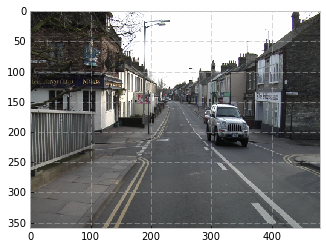

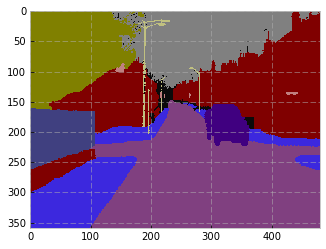

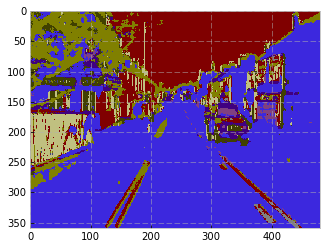

In [27]:
view_sample_predictions(1)

## References

* https://github.com/mattmacy/vnet.pytorch/blob/master/train.py
* https://github.com/SimJeg/FC-DenseNet/blob/master/FC-DenseNet.py